# Generalizing trajectories

<img align="right" src="https://movingpandas.github.io/movingpandas/assets/img/movingpandas.png">

[![Binder](https://mybinder.org/badge_logo.svg)](https://mybinder.org/v2/gh/movingpandas/movingpandas-examples/main?filepath=1-tutorials/7-generalizing-trajectories.ipynb)
[![IPYNB](https://img.shields.io/badge/view-ipynb-hotpink)](https://github.com/movingpandas/movingpandas-examples/blob/main/1-tutorials/7-generalizing-trajectories.ipynb)
[![HTML](https://img.shields.io/badge/view-html-green)](https://movingpandas.github.io/movingpandas-website/1-tutorials/7-generalizing-trajectories.html)

To reduce the size (number of points) of trajectory objects, we can generalize them, for example, using:

- Spatial generalization, such as Douglas-Peucker algorithm
- Temporal generalization by down-sampling, i.e. increasing the time interval between records
- Spatiotemporal generalization, e.g. using Top-Down Time Ratio algorithm

[Documentation](https://movingpandas.readthedocs.io/en/main/trajectorygeneralizer.html)

A closely related type of operation is [trajectory smoothing which is coverd in a separate notebook](./10-smoothing-trajectories.ipynb). 

In [1]:
import pandas as pd
import geopandas as gpd
import movingpandas as mpd
import shapely as shp
import hvplot.pandas 
import matplotlib.pyplot as plt

from geopandas import GeoDataFrame, read_file
from shapely.geometry import Point, LineString, Polygon
from datetime import datetime, timedelta
from holoviews import opts

import warnings
warnings.filterwarnings('ignore')

plot_defaults = {'linewidth':5, 'capstyle':'round', 'figsize':(9,3), 'legend':True}
opts.defaults(opts.Overlay(active_tools=['wheel_zoom'], frame_width=500, frame_height=400))

mpd.show_versions()


MovingPandas 0.17.2

SYSTEM INFO
-----------
python     : 3.10.12 (main, Jun 11 2023, 05:26:28) [GCC 11.4.0]
executable : /usr/bin/python3
machine    : Linux-5.15.90.1-microsoft-standard-WSL2-x86_64-with-glibc2.35

GEOS, GDAL, PROJ INFO
---------------------
GEOS       : None
GEOS lib   : None
GDAL       : 3.6.4
GDAL data dir: /home/anxoide/.local/lib/python3.10/site-packages/fiona/gdal_data
PROJ       : 9.3.0
PROJ data dir: /home/anxoide/.local/lib/python3.10/site-packages/pyproj/proj_dir/share/proj

PYTHON DEPENDENCIES
-------------------
geopandas  : 0.14.1
pandas     : 1.5.3
fiona      : 1.9.5
numpy      : 1.23.5
shapely    : 2.0.2
rtree      : 1.1.0
pyproj     : 3.6.1
matplotlib : 3.5.1
mapclassify: None
geopy      : 2.3.0
holoviews  : 1.18.1
hvplot     : 0.9.0
geoviews   : None
stonesoup  : None


In [3]:
gdf = read_file('../Data/geolife_small.gpkg')
tc = mpd.TrajectoryCollection(gdf, 'trajectory_id', t='t')

In [4]:
gdf

,id,sequence,trajectory_id,tracker,t,geometry
0,1,1,1,19,2008-12-11 04:42:14+00,POINT (116.39131 39.89857)
1,2,2,1,19,2008-12-11 04:42:16+00,POINT (116.39132 39.89862)
2,3,3,1,19,2008-12-11 04:43:26+00,POINT (116.39093 39.89861)
3,4,4,1,19,2008-12-11 04:43:32+00,POINT (116.39083 39.89863)
4,5,5,1,19,2008-12-11 04:43:47+00,POINT (116.38941 39.89872)
...,...,...,...,...,...,...
5903,6993,867,5,2,2009-02-25 14:31:04+00,POINT (116.33719 39.92623)
5904,6994,868,5,2,2009-02-25 14:31:09+00,POINT (116.33721 39.92624)
5905,6995,869,5,2,2009-02-25 14:31:14+00,POINT (116.33726 39.92621)
5906,6996,870,5,2,2009-02-25 14:31:19+00,POINT (116.33729 39.92620)


In [5]:
original_traj = tc.trajectories[1]
print(original_traj)

Trajectory 2 (2009-06-29 07:02:25 to 2009-06-29 11:13:12) | Size: 897 | Length: 38764.6m
Bounds: (116.319212, 39.971703, 116.592616, 40.082514)
LINESTRING (116.590957 40.071961, 116.590905 40.072007, 116.590879 40.072027, 116.590915 40.072004, 


In [6]:
original_traj.df

,id,sequence,trajectory_id,tracker,geometry
t,,,,,
2009-06-29 07:02:25,1556,1090,2,0,POINT (116.59096 40.07196)
2009-06-29 07:02:30,1557,1091,2,0,POINT (116.59091 40.07201)
2009-06-29 07:02:35,1558,1092,2,0,POINT (116.59088 40.07203)
2009-06-29 07:02:40,1559,1093,2,0,POINT (116.59091 40.07200)
2009-06-29 07:02:45,1560,1094,2,0,POINT (116.59096 40.07198)
...,...,...,...,...,...
2009-06-29 11:09:47,2448,1982,2,0,POINT (116.32349 40.00037)
2009-06-29 11:09:57,2449,1983,2,0,POINT (116.32513 40.00057)
2009-06-29 11:10:02,2450,1984,2,0,POINT (116.32688 40.00087)


In [1]:
import pandas as pd
import geopandas as gpd
import movingpandas as mpd
import shapely as shp
import hvplot.pandas 
import matplotlib.pyplot as plt

from geopandas import GeoDataFrame, read_file
from shapely.geometry import Point, LineString, Polygon
from datetime import datetime, timedelta
from holoviews import opts
import base_stream
from OnlineTrajectoryGeneralizer import *

import warnings
warnings.filterwarnings('ignore')

plot_defaults = {'linewidth':5, 'capstyle':'round', 'figsize':(9,3), 'legend':True}
opts.defaults(opts.Overlay(active_tools=['wheel_zoom'], frame_width=500, frame_height=400))

mpd.show_versions()

gdf = read_file('../Data/geolife_small.gpkg')
tc = mpd.TrajectoryCollection(gdf, 'trajectory_id', t='t')
original_traj = tc.trajectories[1]


stream = base_stream.Simulate_stream(original_traj)
generalizer = SquishE(stream)

sq_generalized  =generalizer.generalize(9,0.4)


MovingPandas 0.17.2

SYSTEM INFO
-----------
python     : 3.10.12 (main, Jun 11 2023, 05:26:28) [GCC 11.4.0]
executable : /usr/bin/python3
machine    : Linux-5.15.90.1-microsoft-standard-WSL2-x86_64-with-glibc2.35

GEOS, GDAL, PROJ INFO
---------------------
GEOS       : None
GEOS lib   : None
GDAL       : 3.6.4
GDAL data dir: /home/anxoide/.local/lib/python3.10/site-packages/fiona/gdal_data
PROJ       : 9.3.0
PROJ data dir: /home/anxoide/.local/lib/python3.10/site-packages/pyproj/proj_dir/share/proj

PYTHON DEPENDENCIES
-------------------
geopandas  : 0.14.1
pandas     : 1.5.3
fiona      : 1.9.5
numpy      : 1.23.5
shapely    : 2.0.2
rtree      : 1.1.0
pyproj     : 3.6.1
matplotlib : 3.5.1
mapclassify: None
geopy      : 2.3.0
holoviews  : 1.18.1
hvplot     : 0.9.0
geoviews   : 1.11.0
stonesoup  : None


In [2]:

original_traj.df

,id,sequence,trajectory_id,tracker,geometry
t,,,,,
2009-06-29 07:02:25,1556,1090,2,0,POINT (116.59096 40.07196)
2009-06-29 07:02:30,1557,1091,2,0,POINT (116.59091 40.07201)
2009-06-29 07:02:35,1558,1092,2,0,POINT (116.59088 40.07203)
2009-06-29 07:02:40,1559,1093,2,0,POINT (116.59091 40.07200)
2009-06-29 07:02:45,1560,1094,2,0,POINT (116.59096 40.07198)
...,...,...,...,...,...
2009-06-29 11:09:47,2448,1982,2,0,POINT (116.32349 40.00037)
2009-06-29 11:09:57,2449,1983,2,0,POINT (116.32513 40.00057)
2009-06-29 11:10:02,2450,1984,2,0,POINT (116.32688 40.00087)


,id,sequence,trajectory_id,tracker,geometry
t,,,,,
2009-06-29 07:02:25,1556,1090,2,0,POINT (116.59096 40.07196)
2009-06-29 07:03:15,1567,1101,2,0,POINT (116.59097 40.07200)
2009-06-29 07:05:05,1591,1125,2,0,POINT (116.59149 40.07412)
2009-06-29 07:05:43,1600,1134,2,0,POINT (116.59261 40.07419)
2009-06-29 07:07:00,1618,1152,2,0,POINT (116.59254 40.07430)
...,...,...,...,...,...
2009-06-29 11:09:12,2447,1981,2,0,POINT (116.32636 40.00025)
2009-06-29 11:09:47,2448,1982,2,0,POINT (116.32349 40.00037)
2009-06-29 11:09:57,2449,1983,2,0,POINT (116.32513 40.00057)


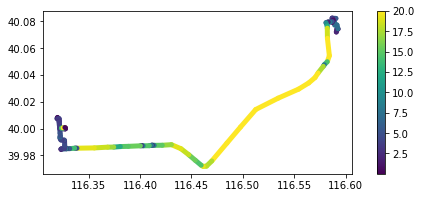

In [3]:

sq_generalized.plot(column='speed', vmax=20, **plot_defaults)




sq_generalized.df

In [4]:

sq_generalized.hvplot(title=f'Movement speed of {sq_generalized.id}', 
                line_width=5.0, c='speed', cmap='RdYlGn', colorbar=True, clim=(0,20)) 

:Overlay
   .WMTS.I   :WMTS   [Longitude,Latitude]
   .Path.I   :Path   [Longitude,Latitude]   (speed)
   .Points.I :Points   [Longitude,Latitude]   (speed,triangle_angle)

In [5]:

original_traj.hvplot(title=f'Movement speed of {original_traj.id}', 
                line_width=5.0, c='speed', cmap='RdYlGn', colorbar=True, clim=(0,20)) 

:Overlay
   .WMTS.I   :WMTS   [Longitude,Latitude]
   .Path.I   :Path   [Longitude,Latitude]   (speed)
   .Points.I :Points   [Longitude,Latitude]   (speed,triangle_angle)

In [22]:
original_traj.df

,id,sequence,trajectory_id,tracker,geometry
t,,,,,
2009-06-29 07:02:25,1556,1090,2,0,POINT (116.59096 40.07196)
2009-06-29 07:02:30,1557,1091,2,0,POINT (116.59091 40.07201)
2009-06-29 07:02:35,1558,1092,2,0,POINT (116.59088 40.07203)
2009-06-29 07:02:40,1559,1093,2,0,POINT (116.59091 40.07200)
2009-06-29 07:02:45,1560,1094,2,0,POINT (116.59096 40.07198)
...,...,...,...,...,...
2009-06-29 11:09:47,2448,1982,2,0,POINT (116.32349 40.00037)
2009-06-29 11:09:57,2449,1983,2,0,POINT (116.32513 40.00057)
2009-06-29 11:10:02,2450,1984,2,0,POINT (116.32688 40.00087)


In [3]:
p = stream.get_points()

In [24]:
from numpy import inf
print(p)
Q[0].append((9, p["id"]))
Q[1][p["id"]] = p
Q[0].sort(reverse=True)
Q

id                                      1567
sequence                                1101
trajectory_id                              2
tracker                                    0
geometry         POINT (116.59097 40.071999)
Name: 2009-06-29 07:03:15, dtype: object


[[(9, 1567), (7, 1566), (0, 1565), (0, 1564), (0, 1563), (0, 1563)],
 {1563: id                                       1563
  sequence                                 1097
  trajectory_id                               2
  tracker                                     0
  geometry         POINT (116.590975 40.071993)
  Name: 2009-06-29 07:03:00, dtype: object,
  1564: id                                       1564
  sequence                                 1098
  trajectory_id                               2
  tracker                                     0
  geometry         POINT (116.590973 40.071995)
  Name: 2009-06-29 07:03:05, dtype: object,
  1565: id                                       1565
  sequence                                 1099
  trajectory_id                               2
  tracker                                     0
  geometry         POINT (116.590971 40.071996)
  Name: 2009-06-29 07:03:10, dtype: object,
  1566: id                                       1566
  seque

In [32]:
Q[0].pop(-1)

IndexError: pop from empty list

In [56]:
index = [i for i in range(len(Q)) if (Q[i][1] == p).all() ]

[0, 1, 2, 3, 4, 5]

0                                                  inf
1    id                                       1564\...
dtype: object

In [32]:
type(p)

pandas.core.series.Series

In [14]:
while stream.is_open():
    stream.get_points()
print(stream.is_open())
stream.get_points()

False


IndexError: single positional indexer is out-of-bounds

<AxesSubplot:>

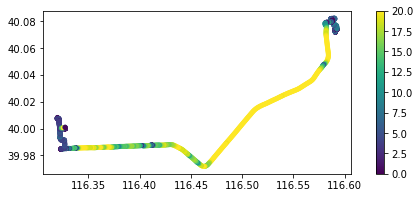

In [25]:
original_traj.plot(column='speed', vmax=20, **plot_defaults)

## Spatial generalization (DouglasPeuckerGeneralizer)

Try different tolerance settings and observe the results in line geometry and therefore also length:

<AxesSubplot:>

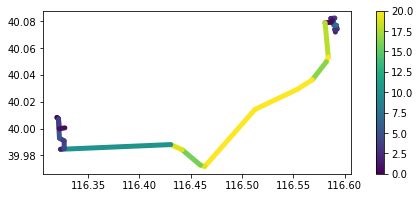

In [7]:
dp_generalized  = mpd.DouglasPeuckerGeneralizer(original_traj).generalize(tolerance=0.001)
dp_generalized.plot(column='speed', vmax=20, **plot_defaults)

In [8]:
dp_generalized.df

,id,sequence,trajectory_id,tracker,geometry
t,,,,,
2009-06-29 07:02:25,1556,1090,2,0,POINT (116.59096 40.07196)
2009-06-29 07:04:30,1583,1117,2,0,POINT (116.59037 40.07396)
2009-06-29 07:04:33,1584,1118,2,0,POINT (116.59037 40.07396)
2009-06-29 07:04:35,1585,1119,2,0,POINT (116.59037 40.07396)
2009-06-29 07:05:45,1601,1135,2,0,POINT (116.59262 40.07419)
2009-06-29 07:07:40,1626,1160,2,0,POINT (116.59196 40.07705)
2009-06-29 07:08:10,1632,1166,2,0,POINT (116.58942 40.07717)
2009-06-29 07:09:20,1646,1180,2,0,POINT (116.58892 40.08157)
2009-06-29 07:09:55,1653,1187,2,0,POINT (116.59036 40.08237)


In [18]:
dp_generalized.to_point_gdf().head(10)

,id,sequence,trajectory_id,tracker,geometry
t,,,,,
2009-06-29 07:02:25,1556,1090,2,0,POINT (116.59096 40.07196)
2009-06-29 07:04:30,1583,1117,2,0,POINT (116.59037 40.07396)
2009-06-29 07:04:33,1584,1118,2,0,POINT (116.59037 40.07396)
2009-06-29 07:04:35,1585,1119,2,0,POINT (116.59037 40.07396)
2009-06-29 07:05:45,1601,1135,2,0,POINT (116.59262 40.07419)
2009-06-29 07:07:40,1626,1160,2,0,POINT (116.59196 40.07705)
2009-06-29 07:08:10,1632,1166,2,0,POINT (116.58942 40.07717)
2009-06-29 07:09:20,1646,1180,2,0,POINT (116.58892 40.08157)
2009-06-29 07:09:55,1653,1187,2,0,POINT (116.59036 40.08237)


In [19]:
print('Original length: %s'%(original_traj.get_length()))
print('Generalized length: %s'%(dp_generalized.get_length()))

Original length: 38764.57548254897
Generalized length: 36921.918452096914


## Temporal generalization (MinTimeDeltaGeneralizer)

An alternative generalization method is to down-sample the trajectory to ensure a certain time delta between records:

<AxesSubplot:>

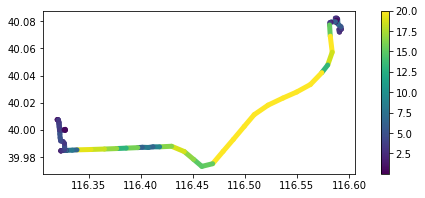

In [20]:
time_generalized = mpd.MinTimeDeltaGeneralizer(original_traj).generalize(tolerance=timedelta(minutes=1))
time_generalized.plot(column='speed', vmax=20, **plot_defaults)

In [21]:
time_generalized.to_point_gdf().head(10)

,id,sequence,trajectory_id,tracker,geometry
t,,,,,
2009-06-29 07:02:25,1556,1090,2,0,POINT (116.59096 40.07196)
2009-06-29 07:03:25,1569,1103,2,0,POINT (116.59069 40.07225)
2009-06-29 07:04:25,1582,1116,2,0,POINT (116.59037 40.07396)
2009-06-29 07:05:25,1595,1129,2,0,POINT (116.59260 40.07411)
2009-06-29 07:06:25,1610,1144,2,0,POINT (116.59258 40.07420)
2009-06-29 07:07:25,1623,1157,2,0,POINT (116.59235 40.07602)
2009-06-29 07:08:25,1635,1169,2,0,POINT (116.58939 40.07794)
2009-06-29 07:09:25,1647,1181,2,0,POINT (116.58911 40.08171)
2009-06-29 07:10:25,1659,1193,2,0,POINT (116.58829 40.08232)


In [22]:
original_traj.to_point_gdf().head(10)

,id,sequence,trajectory_id,tracker,geometry
t,,,,,
2009-06-29 07:02:25,1556,1090,2,0,POINT (116.59096 40.07196)
2009-06-29 07:02:30,1557,1091,2,0,POINT (116.59091 40.07201)
2009-06-29 07:02:35,1558,1092,2,0,POINT (116.59088 40.07203)
2009-06-29 07:02:40,1559,1093,2,0,POINT (116.59091 40.07200)
2009-06-29 07:02:45,1560,1094,2,0,POINT (116.59096 40.07198)
2009-06-29 07:02:50,1561,1095,2,0,POINT (116.59101 40.07196)
2009-06-29 07:02:55,1562,1096,2,0,POINT (116.59099 40.07198)
2009-06-29 07:03:00,1563,1097,2,0,POINT (116.59098 40.07199)
2009-06-29 07:03:05,1564,1098,2,0,POINT (116.59097 40.07200)


## Spatiotemporal generalization (TopDownTimeRatioGeneralizer)

In [23]:
tdtr_generalized = mpd.TopDownTimeRatioGeneralizer(original_traj).generalize(tolerance=0.001)

Let's compare this to the basic Douglas-Peucker result:

<AxesSubplot:>

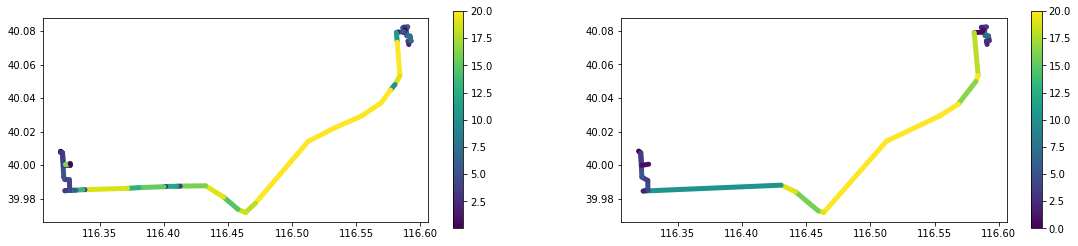

In [24]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(19,4))
tdtr_generalized.plot(ax=axes[0], column='speed', vmax=20, **plot_defaults)
dp_generalized.plot(ax=axes[1], column='speed', vmax=20, **plot_defaults)